In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('notebook-for-the-final-exam')
jovian.set_colab_id('1zO2ioptsKPG8wRQp2VhPTGii-XowCGh_')

<a id='top'></a>
## Table of Contents
1. [Install and import libraries](#lib)
2. [Prepare the dataset for final exam](#data)
3. [Generate test dataframe](#test)
4. [Predictions and local explanations](#explain)
    1. [Case analysis for regression task](#reg)
    2. [Case analysis for classification task](#cls)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id='lib'></a>
# Install and import libraries ([to top](#top))

In [1]:
!pip3 install shap
!pip3 install dice-ml

  Using cached pandas-1.3.5-cp38-cp38-win_amd64.whl (10.2 MB)
  Using cached scikit_learn-1.0.2-cp38-cp38-win_amd64.whl (7.2 MB)


You should consider upgrading via the 'H:\GitHub\BDA-Project\venv\Scripts\python.exe -m pip install --upgrade pip' command.


  Using cached scipy-1.7.3-cp38-cp38-win_amd64.whl (34.2 MB)
  Using cached pytz-2021.3-py2.py3-none-any.whl (503 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)


You should consider upgrading via the 'H:\GitHub\BDA-Project\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np
from joblib import dump, load
import shap
import warnings
warnings.filterwarnings("ignore")
# Sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.base import TransformerMixin, BaseEstimator
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from keras.regularizers import l2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import keras
from numpy.random import seed
seed(1)

# Tensorflow import
import tensorflow as tf
tf.random.set_seed(2)

# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions

%load_ext autoreload
%autoreload 2

# custom transformer for sklearn pipeline
class LabelTransform(TransformerMixin, BaseEstimator):
    def transform(self, X):
      return X

    def fit(self, X, y=None):
      y= np_utils.to_categorical(y)
      return self

def create_model(init='uniform', optimizer='Adam'):
    # define model
    model = Sequential()
    model.add(Dense(64, input_dim=len(train_X.columns), kernel_initializer=init, activation='tanh')) 
    model.add(Dropout(0.2))
    model.add(Dense(100, input_dim=len(train_X.columns))) 
    RandomFourierFeatures(
           output_dim=200, kernel_initializer="gaussian"
       ),
    
    model.add(Dense(2, kernel_initializer=init,kernel_regularizer='l2'))
    model.compile(loss=keras.losses.hinge, optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
  
    return model

np.random.seed(0)

# Fix the probelem that SHAP is not compatible with Pipeline
with open('/usr/local/lib/python3.7/dist-packages/shap/explainers/_permutation.py', 'r') as f:
  filedata = f.read()

# Replace the target string
filedata = filedata.replace('return explanation._old_format()', 'return explanation')

# Write the file out again
with open('/usr/local/lib/python3.7/dist-packages/shap/explainers/_permutation.py', 'w') as file:
  file.write(filedata)

<a id='data'></a>
# Prepare the dataset for final exam ([to top](#top))

In [ ]:
if not Path('/content/drive/MyDrive/BDA/input/df_final.csv').is_file():
  # Read column names from file
  cols = list(pd.read_csv('/content/drive/MyDrive/BDA/input/return_df_pre.csv', nrows =1))

  # Use list comprehension to remove the unwanted column in **usecol**
  df = pd.read_csv('/content/drive/MyDrive/BDA/input/return_df_pre.csv', usecols =[i for i in cols if i not in ['revenue', 'return', 'popularity', 'vote_average', 'vote_count']])

  # shift column 'return_log' to last position
  last_column = df.pop('return_log')
  
  # insert column using insert(position,column_name,
  # first_column) function
  df.insert(len(df.columns), 'return_log', last_column)
  
  # Save the dataframe as a csv file
  df.to_csv('/content/drive/MyDrive/BDA/input/df_final.csv', index=False)

else :
  df = pd.read_csv('/content/drive/MyDrive/BDA/input/df_final.csv')

<a id='test'></a>
# Generate test dataframe ([to top](#top))

In [ ]:
df.iloc[np.random.choice(len(df), 5)].to_csv('/content/drive/MyDrive/BDA/input/df_test.csv', index=False, header=True)
df_test = pd.read_csv('/content/drive/MyDrive/BDA/input/df_test.csv')

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/BDA/input/df_test.csv')
df_test['profitability'] = df_test['return_log'].apply(lambda x: 1 if x >=0 else 0)
df_test

,Australia,Canada,China,France,Germany,Hong Kong,India,Italy,Japan,N_spoken_languages,Russia,South Korea,Spain,United Kingdom,United States of America,actor_label_0,actor_label_1,actor_label_2,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_1,companies_label_2,companies_label_3,director_label_0,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,is_Foreign,is_Friday,is_History,is_Horror,is_Music,is_Musical,is_Mystery,is_Romance,is_Science Fiction,is_Sport,is_TV Movie,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_0,writer_label_1,writer_label_2,writer_label_3,year,return_log,profitability
0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,1,0,0,1,0,1500000.0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,0.000000,0,98.0,1,0,0,0,2001,-1.280314,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,3000000.0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,-0.500000,-0.866025,0,83.0,1,0,0,0,1985,-6.376931,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,30000000.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.500000,-0.866025,0,126.0,1,0,0,0,2007,1.653999,1
3,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,2600000.0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000,0.000000,1,90.0,1,0,0,0,2002,-1.789897,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,558000.0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.866025,-0.500000,0,89.0,0,1,0,0,1931,1.384052,1


<a id='explain'></a>
# Predictions and local explanations ([to top](#top))

<a id='reg'></a>
## Case analysis for regression task ([to top](#top))

Load the trained Gridient boosting regressor.

In [ ]:
gbr_rfe_support = np.load('/content/drive/MyDrive/BDA/models/gbr_rfe_support.npy')
gbr = load('/content/drive/MyDrive/BDA/models/GradientBoostingRegressor.joblib')

Get the predictions and put them with the test dataframe.

In [ ]:
X_reg, y_reg = df_test.drop(['return_log', 'profitability'], axis=1).loc[:, gbr_rfe_support], df_test['return_log']
data_reg = X_reg.copy()
data_reg.loc[:,'predict_reg'] = np.round(gbr.predict(data_reg), 2)
data_reg

,Canada,France,Germany,Hong Kong,Italy,N_spoken_languages,United Kingdom,United States of America,actor_label_0,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_3,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Comedy,is_Drama,is_Horror,is_Mystery,is_Romance,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_2,year,predict_reg
0,0,0,0,0,0,3,0,1,1,1,0,1500000.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1.000000,0.000000,0,98.0,0,2001,-1.69
1,0,0,0,0,0,1,0,1,0,0,0,3000000.0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,-0.500000,-0.866025,0,83.0,0,1985,-0.80
2,0,0,0,0,0,1,0,1,0,1,0,30000000.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0.500000,-0.866025,0,126.0,0,2007,-0.08
3,0,0,0,0,0,2,0,0,1,0,0,2600000.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.000000,0.000000,1,90.0,0,2002,-1.43
4,0,0,0,0,0,1,0,1,0,0,0,558000.0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0.866025,-0.500000,0,89.0,0,1931,0.14


In [ ]:
gbr_explainer = shap.TreeExplainer(gbr)
gbr_shap_values = gbr_explainer(data_reg)

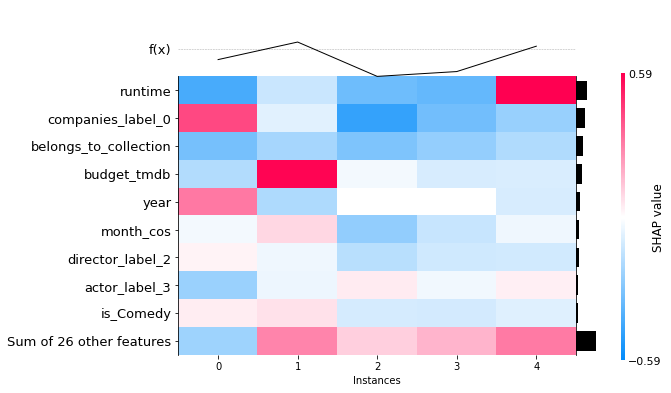

In [ ]:
shap.plots.heatmap(gbr_shap_values)

In [ ]:
shap.initjs()
print("Base value:", y_reg.mean(),
      "\nTarget : ", y_reg.values[0],
      "\nPrediction : ", data_reg['predict_reg'].values[0])
shap.force_plot(gbr_explainer.expected_value, gbr_shap_values.values[0], data_reg.iloc[0])

Base value: -1.2818183164319985 
Target :  -1.2803140375826587 
Prediction :  -1.69


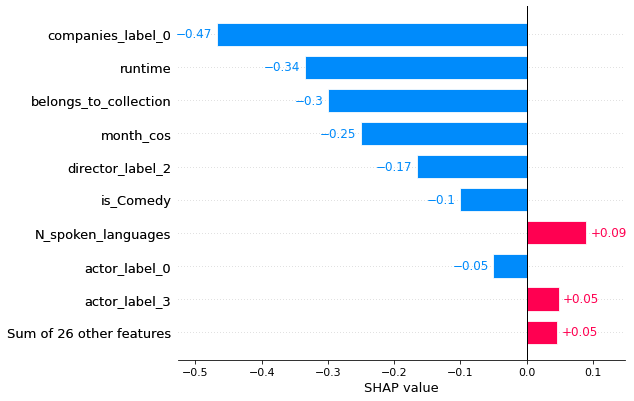

In [ ]:
shap.plots.bar(gbr_shap_values[0])

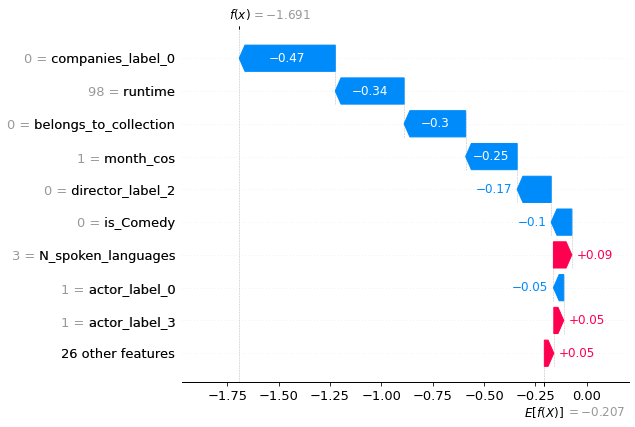

In [ ]:
shap.plots._waterfall.waterfall_legacy(gbr_shap_values.base_values[0][0], gbr_shap_values.values[0], features=gbr_shap_values.data[0], feature_names= X_reg.columns)

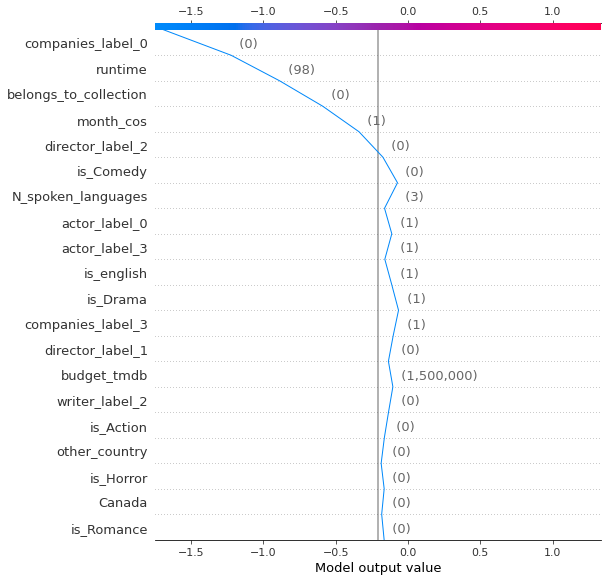

In [ ]:
shap.decision_plot(gbr_explainer.expected_value, gbr_shap_values.values[0], data_reg)

<a id='cls'></a>
## Case analysis for classification task ([to top](#top))

Load the trained stacking classifier.

In [ ]:
stc = load('/content/drive/MyDrive/BDA/models/StackingClassifierPipeline.joblib')
print(stc)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 StackingClassifier(estimators=[('RandomForest',
                                                 RandomForestClassifier(criterion='entropy',
                                                                        min_samples_leaf=2,
                                                                        min_samples_split=9,
                                                                        n_estimators=700,
                                                                        random_state=0)),
                                                ('GradientBossting',
                                                 GradientBoostingClassifier(learning_rate=0.01,
                                                                            max_depth=10,
                                                                            n_estimators=500,
                                                     

Get the predictions and put them with the test dataframe.

In [ ]:
X_cls, y_cls = df_test.drop(['return_log', 'profitability'], axis=1), df_test['profitability']
data_cls = X_cls.copy()
data_cls.loc[:,'predict_cls'] = stc.predict(data_cls)
data_cls

,Australia,Canada,China,France,Germany,Hong Kong,India,Italy,Japan,N_spoken_languages,Russia,South Korea,Spain,United Kingdom,United States of America,actor_label_0,actor_label_1,actor_label_2,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_1,companies_label_2,companies_label_3,director_label_0,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,is_Foreign,is_Friday,is_History,is_Horror,is_Music,is_Musical,is_Mystery,is_Romance,is_Science Fiction,is_Sport,is_TV Movie,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_0,writer_label_1,writer_label_2,writer_label_3,year,predict_cls
0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,1,0,0,1,0,1500000.0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,0.000000,0,98.0,1,0,0,0,2001,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,3000000.0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,-0.500000,-0.866025,0,83.0,1,0,0,0,1985,1
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,30000000.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.500000,-0.866025,0,126.0,1,0,0,0,2007,1
3,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,2600000.0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000,0.000000,1,90.0,1,0,0,0,2002,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,558000.0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.866025,-0.500000,0,89.0,0,1,0,0,1931,1


In [ ]:
stc_explainer = shap.Explainer(stc.predict, X_cls)
stc_shap_values = stc_explainer.shap_values(X_cls)

Permutation explainer: 6it [00:26,  6.73s/it]


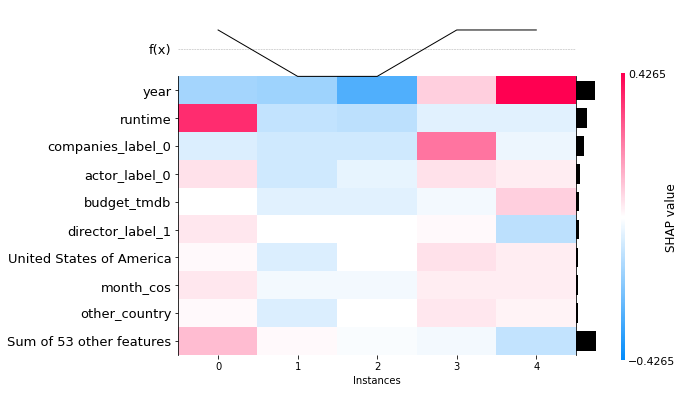

In [ ]:
shap.plots.heatmap(stc_shap_values)

In [ ]:
shap.initjs()
print("Base value:", y_cls.mean(),
      "\nTarget : ", y_cls.values[0],
      "\nPrediction : ", data_cls['predict_cls'].values[0])
shap.force_plot(stc_shap_values.base_values[0], stc_shap_values.values[0], X_cls.iloc[0])

Base value: 0.4 
Target :  0 
Prediction :  0


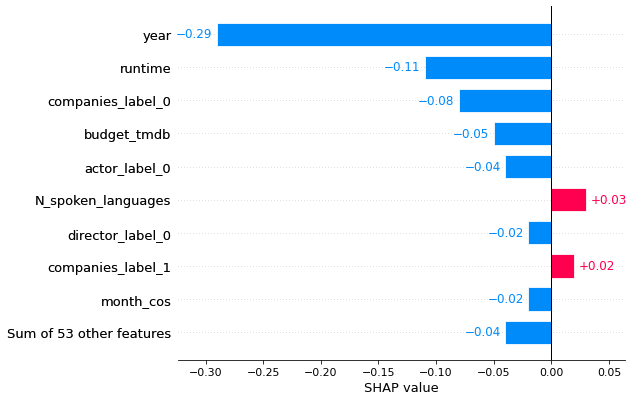

In [ ]:
shap.plots.bar(stc_shap_values[0])

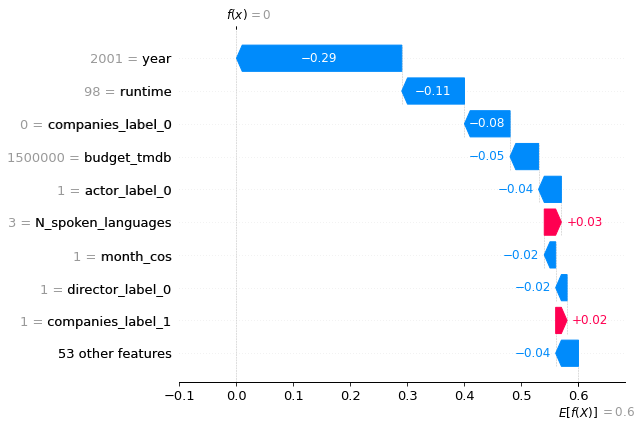

In [ ]:
shap.plots._waterfall.waterfall_legacy(stc_shap_values.base_values[0], stc_shap_values.values[0], features=stc_shap_values.data[0], feature_names= X_cls.columns)

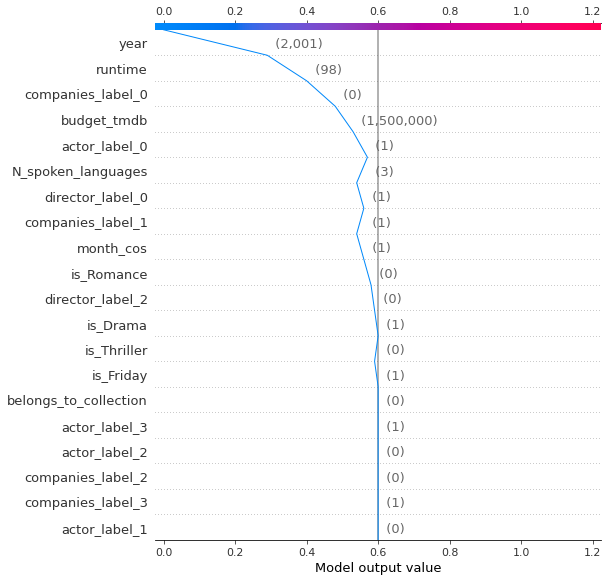

In [ ]:
shap.decision_plot(stc_shap_values.base_values[0], stc_shap_values.values[0], X_cls.iloc[0])

In [ ]:
backend = 'TF'+tf.__version__[0] # TF2 in your case
# Step 1: dice_ml.Data
d = dice_ml.Data(dataframe=data_cls, continuous_features= ['budget_tmdb', 'N_spoken_languages', 'month_sin', 'month_cos', 'runtime','year'], outcome_name='predict_cls')
# Pre-trained ML model
m = dice_ml.Model(model=stc, backend='sklearn')
# DiCE explanation instance
exp = dice_ml.Dice(d, m, method="random")

In [ ]:
negative_cases = data_cls[data_cls['predict_cls']==0].iloc[:,:-1]
negative_cases

,Australia,Canada,China,France,Germany,Hong Kong,India,Italy,Japan,N_spoken_languages,Russia,South Korea,Spain,United Kingdom,United States of America,actor_label_0,actor_label_1,actor_label_2,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_1,companies_label_2,companies_label_3,director_label_0,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,is_Foreign,is_Friday,is_History,is_Horror,is_Music,is_Musical,is_Mystery,is_Romance,is_Science Fiction,is_Sport,is_TV Movie,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_0,writer_label_1,writer_label_2,writer_label_3,year
0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,1,0,0,1,0,1500000.0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0,0.0,0,98.0,1,0,0,0,2001
3,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,2600000.0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1,90.0,1,0,0,0,2002


In [ ]:
dice_exp = exp.generate_counterfactuals(negative_cases.iloc[[np.random.choice(len(negative_cases))]], 
                                        total_CFs=3, 
                                        desired_class="opposite", 
                                        random_seed=42, 
                                        verbose=False,
                                        features_to_vary = negative_cases[negative_cases.columns.difference(['year', 'month_sin', 'month_cos'])].columns.to_list())
dice_exp.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:03<00:00,  3.98s/it]

Query instance (original outcome : 0)


,Australia,Canada,China,France,Germany,Hong Kong,India,Italy,Japan,N_spoken_languages,Russia,South Korea,Spain,United Kingdom,United States of America,actor_label_0,actor_label_1,actor_label_2,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_1,companies_label_2,companies_label_3,director_label_0,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,is_Foreign,is_Friday,is_History,is_Horror,is_Music,is_Musical,is_Mystery,is_Romance,is_Science Fiction,is_Sport,is_TV Movie,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_0,writer_label_1,writer_label_2,writer_label_3,year,predict_cls
0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,2600000.0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1,90.0,1,0,0,0,2002,0



Diverse Counterfactual set (new outcome: 1.0)


,Australia,Canada,China,France,Germany,Hong Kong,India,Italy,Japan,N_spoken_languages,Russia,South Korea,Spain,United Kingdom,United States of America,actor_label_0,actor_label_1,actor_label_2,actor_label_3,belongs_to_collection,budget_tmdb,companies_label_0,companies_label_1,companies_label_2,companies_label_3,director_label_0,director_label_1,director_label_2,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,is_Foreign,is_Friday,is_History,is_Horror,is_Music,is_Musical,is_Mystery,is_Romance,is_Science Fiction,is_Sport,is_TV Movie,is_Thriller,is_War,is_Western,is_english,month_cos,month_sin,other_country,runtime,writer_label_0,writer_label_1,writer_label_2,writer_label_3,year,predict_cls
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-,-,121.6,-,-,-,-,-,1.0
1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1.0


# Save the notebook ([to top](#top))

In [ ]:
!pip install jovian --upgrade --quiet
import jovian
# Execute this to save new versions of the notebook
jovian.commit(project="notebook-for-the-final-exam")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/lilanpei/notebook-for-the-final-exam


'https://jovian.ai/lilanpei/notebook-for-the-final-exam'